# Load data, train model

In [1]:
import sage
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

In [2]:
# Load data
df = sage.datasets.bank()

# Feature names and categorical columns (for CatBoost model)
feature_names = df.columns.tolist()[:-1]
categorical_cols = ['Job', 'Marital', 'Education', 'Default', 'Housing',
                    'Loan', 'Contact', 'Month', 'Prev Outcome']
categorical_inds = [feature_names.index(col) for col in categorical_cols]

In [3]:
# Split data
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=123)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=123)
Y_train = train[:, -1].copy().astype(int)
Y_val = val[:, -1].copy().astype(int)
Y_test = test[:, -1].copy().astype(int)
train = train[:, :-1].copy()
val = val[:, :-1].copy()
test = test[:, :-1].copy()

In [4]:
model = CatBoostClassifier(iterations=100,
                           learning_rate=0.3,
                           depth=10)

model = model.fit(train, Y_train, categorical_inds, eval_set=(val, Y_val),
                  verbose=False)

# Shapley Effects cooperative game

In [5]:
from shapreg import removal, stochastic_games, shapley
from shapreg.utils import crossentropyloss

In [6]:
# Make model callable
model_lam = lambda x: model.predict_proba(x)

# Model extension
marginal_extension = removal.MarginalExtension(train[:128], model_lam)

In [7]:
# Set up game (output loss)
game = stochastic_games.DatasetOutputGame(marginal_extension, test, crossentropyloss)

In [8]:
# Run estimator
%time explanation = shapley.ShapleyRegression(game)

CPU times: user 4min 24s, sys: 18.1 s, total: 4min 43s
Wall time: 3min 9s


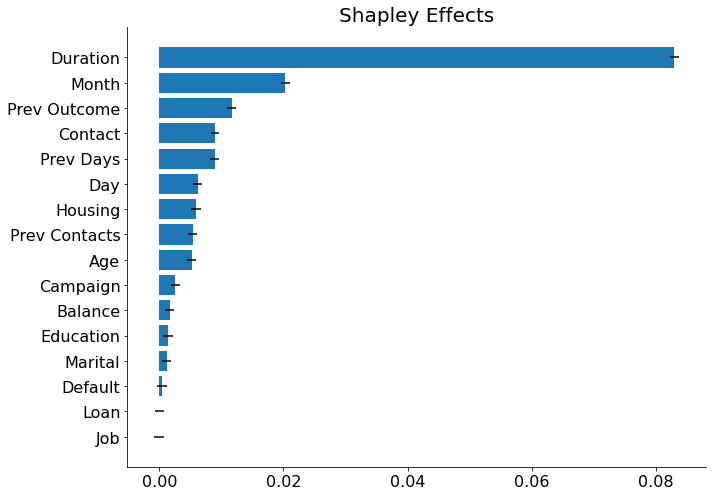

In [9]:
# Plot with 95% confidence intervals
explanation.plot(feature_names, title='Shapley Effects')